In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import random

class DataLoader():
    def __init__(self, filepath):
        cwd = os.getcwd()
        self.basepath = filepath
        try:
            os.stat(self.basepath+"/add_prim_split")
            os.stat(self.basepath+"/few_shot_split")
            os.stat(self.basepath+"/filler_split")
            os.stat(self.basepath+"/length_split")
            os.stat(self.basepath+"/simple_split")
            os.stat(self.basepath+"/template_split")
        except Exception as e:
            raise Exception("Path "+filepath+" doesnt seem to contain the required folders.")

    def load_1a(self):
        train = self.file_loader("/simple_split/tasks_train_simple.txt")
        test = self.file_loader("/simple_split/tasks_test_simple.txt")

        return (np.asarray(train), np.asarray(test))

    def load_1b(self):
        percentile_dict = {}
        splits = ["1", "2", "4", "8", "16", "32", "64"]

        for percentile in splits:
            train = self.file_loader("/simple_split/size_variations/tasks_train_simple_p{}.txt".format(percentile))
            test = self.file_loader("/simple_split/size_variations/tasks_test_simple_p{}.txt".format(percentile))
            
            percentile_dict[percentile] = (np.asarray(train), np.asarray(test))
            
        return percentile_dict

    def load_2(self):
        train = self.file_loader("/length_split/tasks_train_length.txt")
        test = self.file_loader("/length_split/tasks_test_length.txt")

        return (np.asarray(train), np.asarray(test))

    def load_3(self):
        """
        loads the datasets for both parts of the experiment
        the first part where both primitives appear without compositional commands
        the second part where 'jump' primitive appears in
        compositional commands of varying lengths
        returns a dictionary of pairs all possible train/test sets
        """
        data_dict = {}
        nums = ["1", "2", "4", "8", "16", "32"]
        reps = ["1", "2", "3", "4", "5"]

        train = self.file_loader("/add_prim_split/tasks_train_addprim_jump.txt")
        test = self.file_loader("/add_prim_split/tasks_test_addprim_jump.txt")
        data_dict['jump'] = (np.asarray(train), np.asarray(test))

        train = self.file_loader("/add_prim_split/tasks_train_addprim_turn_left.txt")
        test = self.file_loader("/add_prim_split/tasks_test_addprim_turn_left.txt")
        data_dict['lturn'] = (np.asarray(train), np.asarray(test))
        
        for num in nums:
            for rep in reps:
                train = self.file_loader("/add_prim_split/with_additional_examples/tasks_train_addprim_complex_jump_num{}_rep{}.txt".format(num, rep))
                test = self.file_loader("/add_prim_split/with_additional_examples/tasks_test_addprim_complex_jump_num{}_rep{}.txt".format(num, rep))
                
                data_dict['jump_num{}_rep{}'.format(num, rep)] = (np.asarray(train), np.asarray(test))
            
        return data_dict

    def file_loader(self, path):
        sent_list = []
        with open(self.basepath+path, "r") as f:
                    for line in f:
                        sent_list.append(line_splitter(line))
        return sent_list

    
def line_splitter(sentence):
    sent_list = sentence.split("OUT: ")
    sent_list[0] = sent_list[0].strip("IN: ")
    sent_list[1] = sent_list[1].strip("\n")

    return sent_list

# examples:
# 1a :
#   train, test = dl.load_1a()
#   train[0][0] first train sentence, "IN"
#   train[0][1] first train sentence, "OUT"
# 1b :
#   dict = dl.load_1b()
#   train, test = dict["1"] extract the 1 percentile sentences out, split into train and test
#   train[0][0] first train sentence, "OUT"
#   train[0][1] first train sentence, "OUT"
#
# all returns are numpy arrays


In [0]:
#from data_loader import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SOS_token = 0
EOS_token = 1

class Input:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {EOS_token: "EOS"}
        #self.index2word = {}
        self.n_words = 1  # Count SOS and EOS
        #self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

class Output:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        #self.index2word = {}
        self.n_words = 2  # Count SOS and EOS
        #self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


        
def get_embedding(word, lookup_dict, embeds):
    tensor = torch.tensor([lookup_dict[word]], dtype=torch.long)
    return embeds(tensor)


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    output_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, output_tensor)

In [0]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from data_loader import *
#from embeddings import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomLoss(torch.autograd.Function):  
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return

    @staticmethod
    def backward(ctx, grad_output):
        import ipdb; ipdb.set_trace()
        #pass
        return

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.0, layers=1, mode='RNN'):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.layers = layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.hidden_layer = nn.RNN(self.hidden_size, self.hidden_size, num_layers=self.layers)

        if mode == 'LSTM':
        	self.hidden_layer = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.layers)
        elif mode == 'GRU':
        	self.hidden_layer = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.layers)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)

        output, hidden = self.hidden_layer(output, hidden)
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.layers, 1, self.hidden_size, device=device)
        nn.init.xavier_uniform_(hidden, gain=nn.init.calculate_gain('relu'))
        return hidden


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, dropout_p=0.0, layers=1, attention=False, mode='RNN'):
    	#layers should be either 1 or 2
    	#in the latter case remember to pass a pair of hidden states!
    	#mode can be either 'LSTM', 'GRU' or 'RNN'
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.layers = layers
        self.max_length = max_length
        self.attention = attention
        self.mode = mode

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        if self.attention:
	        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
	        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.hidden_layer = nn.RNN(self.hidden_size, self.hidden_size, num_layers=self.layers)

        if mode == 'LSTM':
        	self.hidden_layer = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.layers)
        elif mode == 'GRU':
        	self.hidden_layer = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.layers)
        
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs=None):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)

        if self.attention:
	        attn_weights = F.softmax(
	            self.attn(torch.cat((output[0], hidden[0]), 1)), dim=1)
	        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
	                                 encoder_outputs.unsqueeze(0))
	        output = torch.cat((output[0], attn_applied[0]), 1)
        	output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.hidden_layer(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.layers, 1, self.hidden_size, device=device)
        nn.init.xavier_uniform_(hidden, gain=nn.init.calculate_gain('relu'))
        return hidden

def train(input_tensor, output_tensor, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion, max_length, clipping_value=5, mode='RNN'):
    encoder_hidden1 = encoder.initHidden()
    encoder_hidden2 = encoder.initHidden()

    encoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    output_length = output_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        if mode == 'LSTM':
            encoder_output, (encoder_hidden1, encoder_hidden2) = encoder(input_tensor[ei], (encoder_hidden1, encoder_hidden2))
        else: 
            encoder_output, encoder_hidden1 = encoder(input_tensor[ei], encoder_hidden1)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden1 = encoder_hidden1
    decoder_hidden2 = encoder_hidden2

    forcing = random.random() > 0.5

    if forcing:
        for di in range(output_length):
            if mode == 'LSTM':
                decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            else:
                decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
            decoder_input = output_tensor[di]
            loss += criterion(decoder_output, output_tensor[di])

            if decoder_input.item() == EOS_token:
                break
    else:
        for di in range(output_length):
            if mode == 'LSTM':
                decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            else:
                decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, output_tensor[di])
            
            if decoder_input.item() == EOS_token:
                break

    #loss = CustomLoss
    loss.backward()

    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clipping_value)
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clipping_value)

    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / output_length

    
def trainIters(encoder, decoder, train_data, input_lang, output_lang, max_length, learning_rate=0.001, mode='RNN'):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    losses = []
    print(train_data.shape[0])
    print_loss_total = 0

    for iter in range(train_data.shape[0]):
        training_pair = tensorsFromPair(train_data[iter], input_lang, output_lang)
        input_tensor = training_pair[0]
        output_tensor = training_pair[1]

        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
            output_tensor = output_tensor.cuda()
        
        loss = train(input_tensor, output_tensor, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion, max_length, mode=mode)
        print_loss_total += loss

        if iter % 500 == 0:
            print_loss_avg = print_loss_total / 500
            losses.append(print_loss_avg)
            print(iter)
            print(print_loss_avg)
            print_loss_total = 0

    return losses

dl = DataLoader("/content/drive/My Drive/SCAN")
#dl = DataLoader("SCAN")
train_data, test_data = dl.load_1a()

MAX_LENGTH = max([len(x[0].split()) for x in train_data]) + 1

train_in = Input("train_input")
train_out = Output("train_output")

test_in = Input("test_input")
test_out = Output("test_output")

for datapoint in train_data:
        train_in.addSentence(datapoint[0])
        train_out.addSentence(datapoint[1])

for datapoint in test_data:
        test_in.addSentence(datapoint[0])
        test_out.addSentence(datapoint[1])

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

train_data = train_data[np.random.choice(train_data.shape[0], 100000, replace=True), :]

def train_and_save(model, dropout, att, layers, model_name):
    encoder = Encoder(train_in.n_words, 200, layers=layers, mode=model, dropout_p=dropout)
    decoder = Decoder(200, train_out.n_words, layers=layers, max_length=MAX_LENGTH, mode=model, dropout_p=dropout, attention=att)

    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

    losses = trainIters(encoder, decoder, train_data, train_in, train_out, MAX_LENGTH, mode=model)
    plt.plot(losses)
    plt.title(model+'_layers='+str(layers)+'_drop='+str(dropout)+'_attention='+str(att))
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()
    torch.save(encoder.state_dict(), "/content/drive/My Drive/"+model_name+"_encoder.pt")
    torch.save(decoder.state_dict(), "/content/drive/My Drive/"+model_name+"_decoder.pt")

100000
0
0.004053722381591797
500
1.6157764356072473
1000
1.4786443489838839
1500
1.3349559540668643
2000
1.237482527106738
2500
1.2048844116444806
3000
1.1213750610288244
3500
1.1138152122023026
4000
1.1331564047758307
4500
1.138337100180784
5000
1.0454982528420502
5500
1.0444512032336564
6000
1.0535016994394057
6500
1.011065318527992
7000
1.0105239068144347
7500
1.0557395027517682
8000
0.9746558038022699
8500
0.9607218682442356
9000
0.9370454927524693
9500
0.9781667470850707
10000
0.9636122657426675
10500
0.9285020268789306
11000
0.8907043074577388
11500
0.9691319823468024
12000
0.8884270934670507
12500
0.9072940333532116
13000
0.8784236317306434
13500
0.9149250172613947
14000
0.8394300129822603
14500
0.8398049872610075
15000
0.8605342201424327
15500
0.8597545794685707
16000
0.8710525108041738
16500
0.8413611473743788
17000
0.855903657095019
17500
0.8780948184160063
18000
0.8779150270665093
18500
0.9034816086544705
19000
0.8636207935576824
19500
0.8162860873971814
20000
0.85679717643

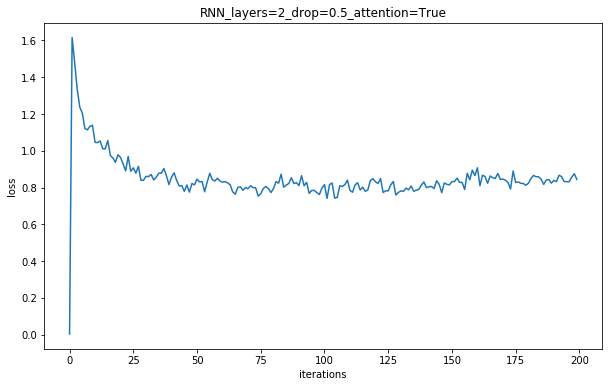

100000
0
0.00424412186940511
500
1.6379638132660244
1000
1.4608449566147355
1500
1.4568566864274886
2000
1.3636041160188486
2500
1.3767447657527856
3000
1.3521620253348332
3500
1.373233333647278
4000
1.3048160461838243
4500
1.3782094583454436
5000
1.3228810591142077
5500
1.3001232482014666
6000
1.3225094940304767
6500
1.2624578532468849
7000
1.2477734137314485
7500
1.2815077811150732
8000
1.251133095195877
8500
1.2645490663423153
9000
1.2138432305283489
9500
1.206761358850896
10000
1.1815707665631323
10500
1.2154377480500187
11000
1.1934277647014102
11500
1.1216180219249023
12000
1.153694273820445
12500
1.1230065641406783
13000
1.1664295190514145
13500
1.1654587477654974
14000
1.1126598863202604
14500
1.1194099963745512
15000
1.1485026948816732
15500
1.0819712286753709
16000
1.1089715360166155
16500
1.1243571793690437
17000
1.0815651194555815
17500
1.1520885978368147
18000
1.1206770088910023
18500
1.1214998126785478
19000
1.1379688885926305
19500
1.099405684775709
20000
1.0798998589255

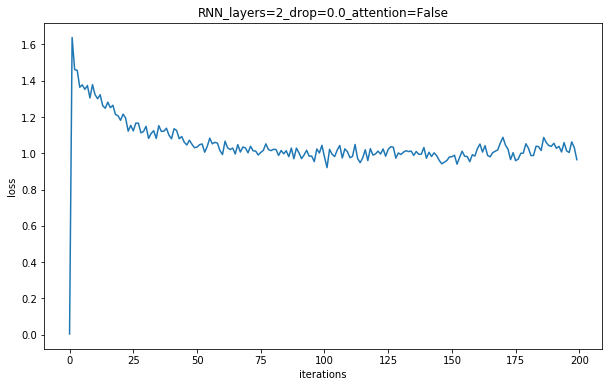

100000
0
0.0043917598724365235
500
1.649681732104447
1000
1.5166969949045024
1500
1.416168650032793
2000
1.3275097128590614
2500
1.3130876607408606
3000
1.2758098993953635
3500
1.2683150968310346
4000
1.2627711744424754
4500
1.271868857665646
5000
1.1917360771064032
5500
1.1587313355975206
6000
1.1447663508142507
6500
1.0787883431461318
7000
1.073755593857771
7500
1.084887206099844
8000
1.0288508315133689
8500
1.053158991316643
9000
1.0050022975830004
9500
0.9834749786537896
10000
0.9564876953465332
10500
1.0033121526654802
11000
1.0076487484209282
11500
0.9648039313515699
12000
1.0057331990332476
12500
0.9131840661087286
13000
0.9242590916941548
13500
0.9104702012502291
14000
0.9362416225085992
14500
0.9166766684152999
15000
0.9690915763314425
15500
0.8959004619085242
16000
0.9579748237995256
16500
0.8996044622561601
17000
0.9058878369235288
17500
0.9231478040315534
18000
0.91742740062078
18500
0.8751262866715117
19000
0.9777570305306776
19500
0.9056564362794713
20000
0.90019337868970

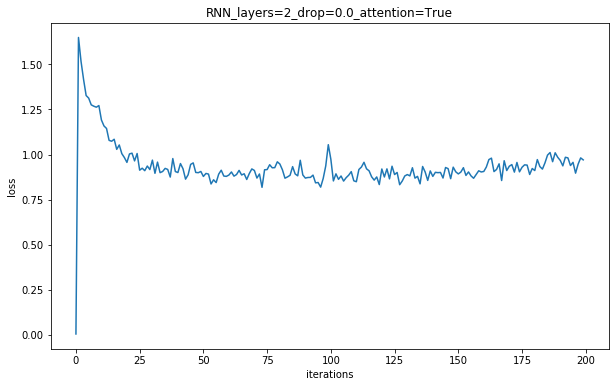

100000
0
0.00264428440729777
500
1.5599553357659328
1000
1.3456536275924817
1500
1.2517398129639354
2000
1.1888996047244478
2500
1.1368657370317876
3000
1.0825096752668628
3500
1.0147001439757857
4000
0.9933233476950456
4500
1.0313617621379563
5000
0.9593866124031215
5500
0.9562831424354639
6000
0.9127554163803064
6500
0.9259225104731963
7000
0.8429803087919481
7500
0.7643813960842095
8000
0.8162412818318321
8500
0.8147731298245652
9000
0.7834940944594055
9500
0.7373417778311648
10000
0.7662210300578071
10500
0.7560353402701981
11000
0.7526272229171749
11500
0.7452705402825833
12000
0.7683313378053389
12500
0.8436284001659271
13000
0.7227144450410402
13500
0.667201767720858
14000
0.7556899354777744
14500
0.6773702808999154
15000
0.7386218831720361
15500
0.6664678649906756
16000
0.6636881941919435
16500
0.6933041065479473
17000
0.7125818110941519
17500
0.6838291606524849
18000
0.6830120417932483
18500
0.671932024144454
19000
0.7162271053934692
19500
0.6429265206775855
20000
0.6382461538

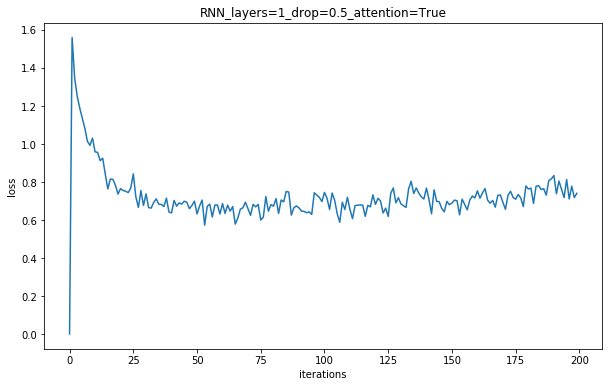

100000
0
0.004053852717081706
500
1.6593911937131627
1000
1.4771740831039593
1500
1.4161493705086763
2000
1.3922588443743389
2500
1.3718342972365185
3000
1.330927035298193
3500
1.3059667494577536
4000
1.301490338106799
4500
1.302257885567624
5000
1.2609441040926126
5500
1.326198658473797
6000
1.3078252894204385
6500
1.2761176568225705
7000
1.2222396393376163
7500
1.218634363068582
8000
1.2293976554689865
8500
1.226908680573994
9000
1.184908676471062
9500
1.2368602961610418
10000
1.20967821921158
10500
1.208485966501412
11000
1.2326466013353392
11500
1.1620442525811794
12000
1.2078593157106738
12500
1.1644483521373243
13000
1.1326510501044564
13500
1.1832357807679033
14000
1.1024866031577458
14500
1.1382584377753266
15000
1.0995322420625622
15500
1.1306231985564887
16000
1.0818300334223696
16500
1.1140624491694187
17000
1.0798246504924838
17500
1.1330461613578124
18000
1.092225169103753
18500
1.0165083385104925
19000
1.0824264748619952
19500
1.02936711096734
20000
1.073437399386866
2050

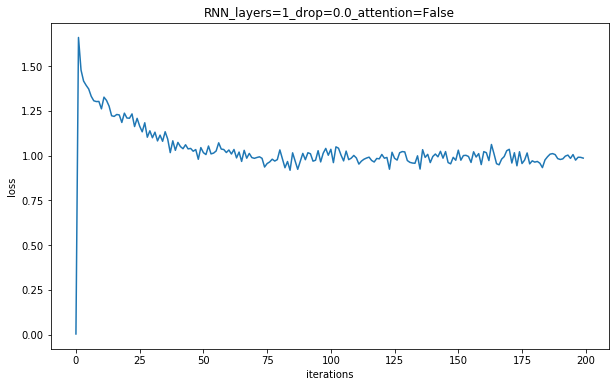

100000
0
0.004438131332397461
500
1.5580900991327933
1000
1.346361596696458
1500
1.2640014273783242
2000
1.1507979078739214
2500
1.1206769005973283
3000
1.0778380786267363
3500
1.0288114924090077
4000
0.9891441398585896
4500
0.9941418247868502
5000
0.9092331093389738
5500
0.924522622099133
6000
0.9183615751133171
6500
0.8623540539112967
7000
0.8396068832632569
7500
0.8595636647472941
8000
0.846773488283743
8500
0.8167047779668812
9000
0.827394416094237
9500
0.7902528995522718
10000
0.7746040126145349
10500
0.7997921456855588
11000
0.7798457722315345
11500
0.7708060709630654
12000
0.7479211460569055
12500
0.7868085283067168
13000
0.7312032942542406
13500
0.7137110272423601
14000
0.7427160369081147
14500
0.7346487455687176
15000
0.7070124733925812
15500
0.7080297462056889
16000
0.7233310788591097
16500
0.7726510640779297
17000
0.6944320684559369
17500
0.7116495175662154
18000
0.6612652597908467
18500
0.6782245753064859
19000
0.7007245443237943
19500
0.6353037252321149
20000
0.68829963663

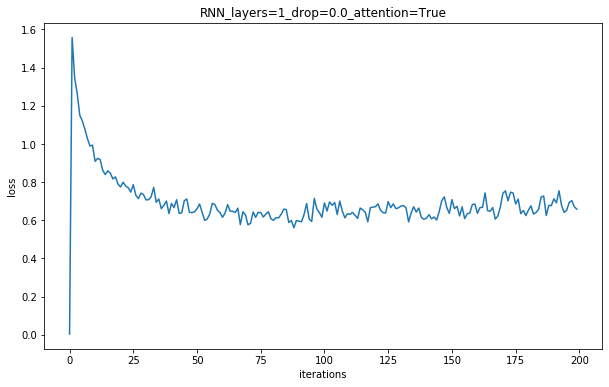

In [0]:
model='RNN'
train_and_save(model, 0.5, True, 2, 'srn2_att_drop')
train_and_save(model, 0.0, False, 2, 'srn2')
train_and_save(model, 0.0, True, 2, 'srn2_att')
train_and_save(model, 0.5, True, 1, 'srn1_att_drop')
train_and_save(model, 0.0, False, 1, 'srn1')
train_and_save(model, 0.0, True, 1, 'srn1_att')

In [17]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from data_loader import *
#from embeddings import *
#from layers_attempt import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(train_in.n_words, 200, layers=1, mode="RNN")
encoder.load_state_dict(torch.load("/content/drive/My Drive/srn1_att_encoder.pt"))

decoder = Decoder(200, train_out.n_words, layers=1, max_length=MAX_LENGTH, mode="RNN", attention=True)
decoder.load_state_dict(torch.load("/content/drive/My Drive/srn1_att_decoder.pt"))

if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

def evaluate(encoder, decoder, sentence, input_lang, output_lang, mode, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
        input_length = input_tensor.size()[0]
        encoder_hidden1 = torch.zeros(encoder.layers, 1, encoder.hidden_size, device=device)
        encoder_hidden2 = torch.zeros(encoder.layers, 1, encoder.hidden_size, device=device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            if mode == 'LSTM':
                encoder_output, (encoder_hidden1, encoder_hidden2) = encoder(input_tensor[ei], (encoder_hidden1, encoder_hidden2))
            else: 
                encoder_output, encoder_hidden1 = encoder(input_tensor[ei], encoder_hidden1)
                encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden1 = encoder_hidden1
        decoder_hidden2 = encoder_hidden2

        decoded_words = []
        for di in range(max_length):
            if mode == 'LSTM':
                decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            else:
                decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        return decoded_words

def evaluateIters(test_data, encoder, decoder, lang_in, lang_out, mode):
    hit = 0
    miss = 0
    iters = 0
    hit_idx = []
    miss_idx = []

    for idx, test_point in enumerate(test_data):
        pred = evaluate(encoder, decoder, test_point[0], lang_in, lang_out, mode=mode)
        pred = " ".join(pred)
        if pred == test_point[1]:
            hit += 1
            hit_idx.append(idx)
        else:
            miss += 1
            miss_idx.append(idx)
        iters += 1

        if iters % 100 == 0:
            print(iters)
            print(hit)

    return hit, hit_idx, miss, miss_idx

hit, hit_idx, miss, miss_idx = evaluateIters(test_data, encoder, decoder, train_in, train_out, mode="RNN")

100
7
200
14
300
23
400
29
500
35
600
42
700
51
800
58
900
63
1000
70
1100
76
1200
84
1300
88
1400
93
1500
101
1600
108
1700
113
1800
124
1900
125
2000
132
2100
138
2200
143
2300
151
2400
158
2500
166
2600
175
2700
192
2800
202
2900
212
3000
217
3100
225
3200
230
3300
239
3400
247
3500
260
3600
263
3700
266
3800
268
3900
278
4000
281
4100
293


In [18]:
hit/len(test_data)

0.07197513151602104

In [0]:
" ".join(evaluate(encoder, decoder, test_data[4000][0], train_in, train_out)) #3742

'I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT'

In [0]:
test_data[4000][0]

'turn left thrice after turn opposite right twice'

In [0]:
max([len(x[0].split()) for x in train_data])

NameError: ignored

In [0]:
str(True)

'True'